In [1]:
import pandas as pd
from cartopy import crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
from xhistogram.xarray import histogram
import numpy as np
import gfdl_utils as gu
import glob
import re
from scipy.interpolate import griddata
import geopy
import cmocean
import xesmf as xe
import sectionate
from geopy import distance
import sys
sys.path.insert(0, '/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/src')
from src import *

In [2]:
plotsdir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/figures/" + x
datadir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/data/" + x

In [3]:
# GLODAP:model variable naming conventions
model2glodap_names = {'cfc12':'cfc12','cfc11':'cfc11','sf6':'sf6','thetao':'theta','so':'salinity'}
variable_kwargs = {
    'cfc12':{'conversion':1e12/1035,'cmap':'Greens','units':'pmolkg-1'},
    'cfc11':{'conversion':1e12/1035,'cmap':'PuRd','units':'pmolkg-1'},
    'sf6':{'conversion':1e12/1035 * 1e3,'cmap':'PuRd','units':'fmolkg-1'},
    'theta':{'conversion':1,'cmap':cmocean.cm.thermal,'units':'degK','bins':np.arange(-2,35,0.2),'anombins':np.arange(-4,4.05,0.05)},
    'salinity':{'conversion':1,'cmap':cmocean.cm.haline,'units':'psu','bins':np.arange(32,37,0.05),'anombins':np.arange(-1,1.02,0.02)}
}

In [4]:
from dask_jobqueue import SLURMCluster  # setup dask cluster 
cluster = SLURMCluster(
    cores=36,
    processes=1,
    memory='192GB',
    walltime='02:00:00',
    queue='compute',
    interface='ib0')
print(cluster.job_script())
cluster.scale(jobs=16)
from dask.distributed import Client
client = Client(cluster)


#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p compute
#SBATCH -n 1
#SBATCH --cpus-per-task=36
#SBATCH --mem=179G
#SBATCH -t 02:00:00

/vortexfs1/home/anthony.meza/mambaforge/envs/atm_rivers/bin/python -m distributed.cli.dask_worker tcp://172.16.3.97:45034 --nthreads 36 --memory-limit 178.81GiB --name dummy-name --nanny --death-timeout 60 --interface ib0



In [5]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.16.3.97:45034,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [9]:
def read_CM4X(fname):  
    ds =  xr.open_mfdataset(
        fname,
        data_vars="minimal",
        coords="minimal",
        compat="override",
        parallel=True,
        chunks={"latitude":20, "longitude":20, "zl":-1, "year":20},
        engine="zarr")
    ds = ds.drop(["lat", "lon"])
    ds = ds.rename({"geolat":"lat", "geolon":"lon"})
    ds = approximate_z(ds)
    ds["z"] = ds["z"].transpose("year", "zl", "yh", "xh")
    ds["thkcello"] = ds["thkcello"].transpose("year", "zl", "yh", "xh")
    return ds

ds = read_CM4X(datadir("CM4Xp125_historical_transient_tracers.zarr"))
ds_lo = read_CM4X(datadir("CM4Xp25_historical_transient_tracers.zarr"))

# ds = ds.where(ds['thkcello'] > 9.999975e-3)  

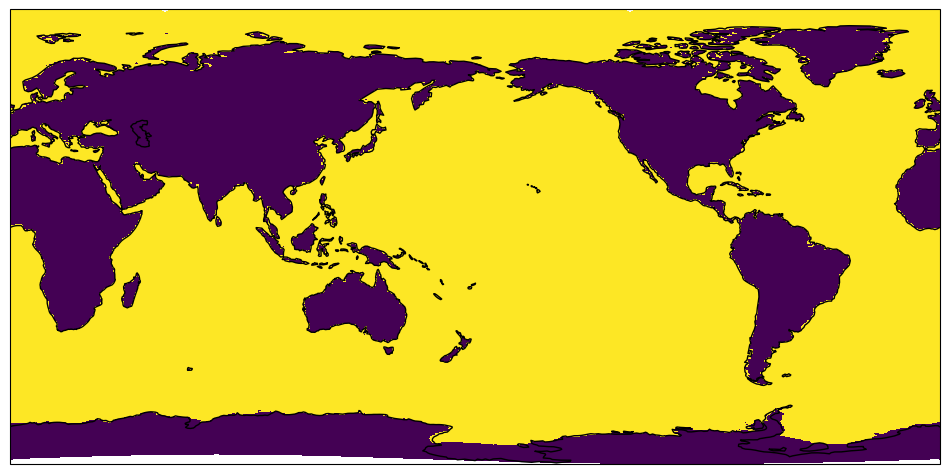

In [13]:
fig, axes = plt.subplots(1, 1, figsize=(12, 10), subplot_kw={'projection':ccrs.PlateCarree(central_longitude = 180)})

axes.pcolormesh(ds.lon, ds.lat, (ds["deptho"] > 0.1), transform=ccrs.PlateCarree())
axes.coastlines()

In [14]:
def time_z_mean(ds, varn, ystart, yend, zmin, zmax):
    ds_mean = ds[varn].sel(year = slice(ystart, yend)).mean(["year"]).compute()
    ds_z_mean = ds.z.sel(year = slice(ystart, yend)).mean(["year"]).compute()
    ds_thick_mean = ds.thkcello.sel(year = slice(ystart, yend)).mean(["year"]).compute()
    
    mask = (ds_z_mean > zmin) * (ds_z_mean < zmax)
    weights = mask * ds_thick_mean

    ds_mean_level = (weights * ds_mean).sum("zl") / weights.sum("zl")
    return ds_mean_level * variable_kwargs[varn]['conversion']

In [30]:
ds_GLODAPP = xr.open_dataset(datadir("GLODAP_gridded.nc")).compute()
cfc_gridded = ds_GLODAPP.G2cfc11.compute()

/vortexfs1/home/anthony.meza/mambaforge/envs/atm_rivers/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


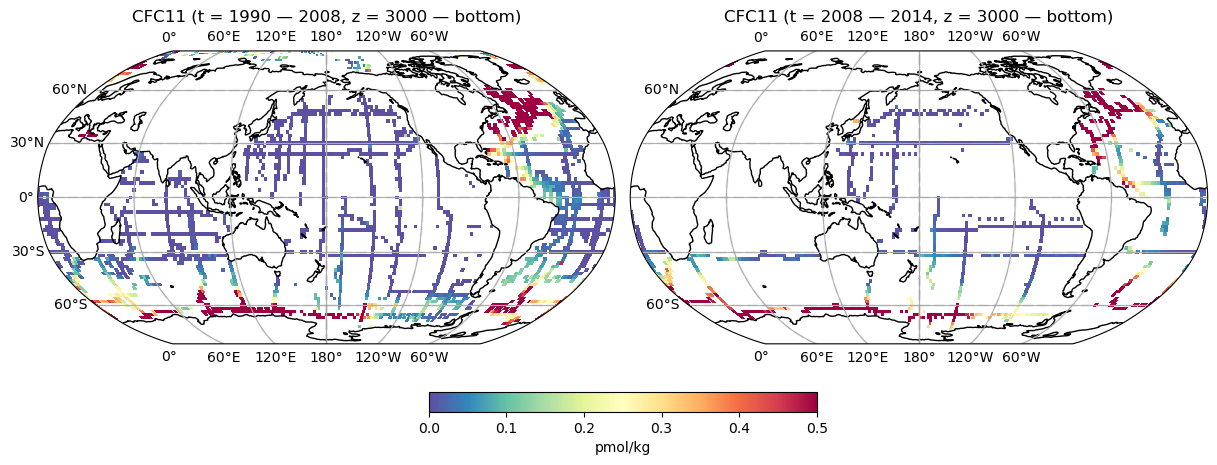

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(12, 10), subplot_kw={'projection':ccrs.Robinson(central_longitude = 180)})
[a.gridlines() for a in axes]
[a.coastlines() for a in axes]
# [a.set_extent([-180, 360, -90, 60]) for a in axes]
cfc_gridded.sel(time = slice(1990, 2008), z = slice(3000, 6000)).mean(["time", "z"]).T.plot.pcolormesh(ax=axes[0], 
                                                                        vmin = 0, vmax = 0.5, cmap = "Spectral_r", 
                                                                        add_colorbar = False, transform=ccrs.PlateCarree())

cm = cfc_gridded.sel(time = slice(2008, 2014), z = slice(3000, 6000)).mean(["time", "z"]).T.plot.pcolormesh(ax=axes[1], 
                                                                        vmin = 0, vmax = 0.5, cmap = "Spectral_r", 
                                                                        add_colorbar = False, transform=ccrs.PlateCarree())
fig.tight_layout()
fig.colorbar(cm, ax = axes[:], orientation = "horizontal", fraction  = 0.02, pad = 0.05, label = "pmol/kg")

axes[0].set_title("CFC11 (t = 1990 — 2008, z = 3000 — bottom)")
axes[1].set_title("CFC11 (t = 2008 — 2014, z = 3000 — bottom)")
for (i, a) in enumerate(axes):
    gl = a.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.1, linestyle='--') 
    if i == 1: 
        gl.ylabels_left = False

fig.savefig(plotsdir("GLODAP_planar_view.png"), dpi = 400, bbox_inches = "tight")

/vortexfs1/home/anthony.meza/mambaforge/envs/atm_rivers/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


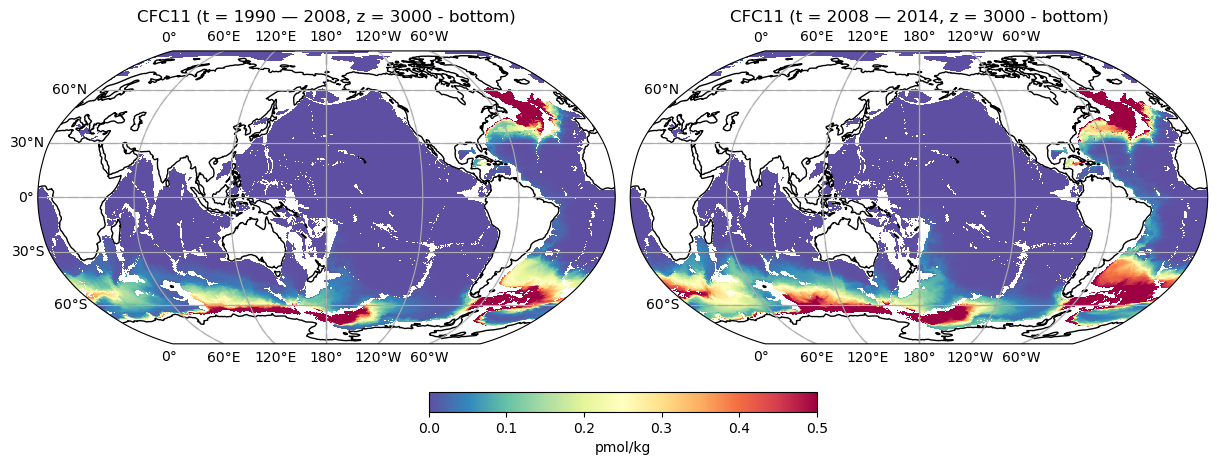

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(12, 10), subplot_kw={'projection':ccrs.Robinson(central_longitude = 180)})
# [a.set_extent([20, 290, -90, 73], ccrs.PlateCarree()) for a in axes]
[a.gridlines() for a in axes]
[a.coastlines() for a in axes]

tmp = time_z_mean(ds, "cfc11", 1990, 2008, -6000, -3000)
tmp = tmp.compute()
axes[0].pcolormesh(tmp.lon, tmp.lat, tmp, vmin = 0, vmax = 0.5, cmap = "Spectral_r", transform=ccrs.PlateCarree())

tmp =  time_z_mean(ds,  "cfc11", 2008, 2014, -6000, -3000)
tmp = tmp.compute()
cm = axes[1].pcolormesh(tmp.lon, tmp.lat, tmp, vmin = 0, vmax = 0.5, cmap = "Spectral_r", transform=ccrs.PlateCarree())

fig.tight_layout()
fig.colorbar(cm, ax = axes[:], orientation = "horizontal", fraction  = 0.02, pad = 0.05, label = "pmol/kg")

for (i, a) in enumerate(axes):
    gl = a.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.1, linestyle='--') 
    if i == 1: 
        gl.ylabels_left = False

axes[0].set_title("CFC11 (t = 1990 — 2008, z = 3000 - bottom)")
axes[1].set_title("CFC11 (t = 2008 — 2014, z = 3000 - bottom)")
fig.savefig(plotsdir("CM4X_p125_planar_view.png"), dpi = 400, bbox_inches = "tight")

/vortexfs1/home/anthony.meza/mambaforge/envs/atm_rivers/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


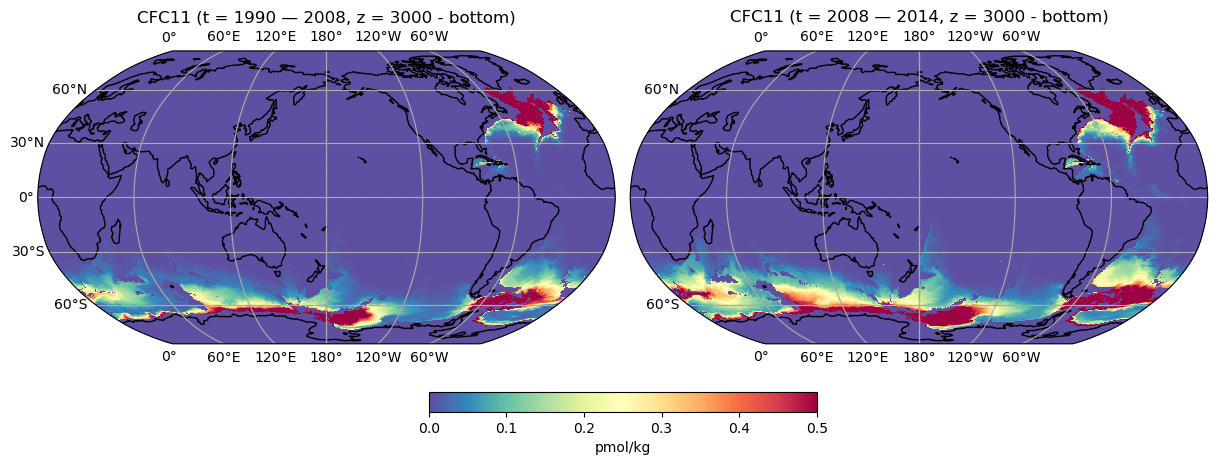

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(12, 10), subplot_kw={'projection':ccrs.Robinson(central_longitude = 180)})
# [a.set_extent([20, 290, -90, 73], ccrs.PlateCarree()) for a in axes]
[a.gridlines() for a in axes]
[a.coastlines() for a in axes]

tmp = time_z_mean(ds_lo, "cfc11", 1990, 2008, -6000, -3000)
tmp = tmp.compute()
axes[0].pcolormesh(tmp.lon, tmp.lat, tmp, vmin = 0, vmax = 0.5, cmap = "Spectral_r", transform=ccrs.PlateCarree())

tmp =  time_z_mean(ds_lo,  "cfc11", 2008, 2014, -6000, -3000)
tmp = tmp.compute()
cm = axes[1].pcolormesh(tmp.lon, tmp.lat, tmp, vmin = 0, vmax = 0.5, cmap = "Spectral_r", transform=ccrs.PlateCarree())

fig.tight_layout()
fig.colorbar(cm, ax = axes[:], orientation = "horizontal", fraction  = 0.02, pad = 0.05, label = "pmol/kg")

for (i, a) in enumerate(axes):
    gl = a.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.1, linestyle='--') 
    if i == 1: 
        gl.ylabels_left = False

axes[0].set_title("CFC11 (t = 1990 — 2008, z = 3000 - bottom)")
axes[1].set_title("CFC11 (t = 2008 — 2014, z = 3000 - bottom)")
fig.savefig(plotsdir("CM4X_p25_planar_view.png"), dpi = 400, bbox_inches = "tight")